# Explore here

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import missingno as msno
from sklearn.impute import KNNImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import os
import seaborn as sns

In [87]:
df = pd.read_csv('/workspaces/pauline---machine-learning-python-template/data/raw/AB_NYC_2019.csv')
pd.set_option('display.max_columns', None)
df.head()



,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


A continuación vamos a hacer una EDA, para analizar, limpiar y optimizar el dataset, y prepararlo para el modelo de ML y nuestra meta que es predecir los precios. 

In [88]:
#Queremos conocer dimensión del DF:
df.shape

(48895, 16)

In [89]:
#Y tipo de datos: 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [90]:
# Y num de valores unicas: 
df.nunique()

#Sirve para limpiar el DF porque por ejemplo: 
    #Si hay columnas que devuelven 1, se pueden eliminar, no nos aportan ninguna info para la predicción --> en ese caso no hay
    #Si hay columnas con pocas valores diferentes, se puede analizar haciendo escala, ranking --> en ese caso podremos hacerlo con room_type, y neighbourhood_group, más adelante

id                                48895
name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [91]:
#Primero seguimos con la limpieza global a y eliminamos los elementos que identificamos rapidamente como inutiles para la predicción:

    #Los 0 en la columna price que no tienen sentido, eliminamos esas líneas: 
df = df[df['price'] > 0]

    #host_name y name --> se ve que hay duplicados y no nos sirve porque tenemos las columnas ID 

df.drop(['host_name'], axis=1, inplace=True)
df.drop(['name'], axis=1, inplace=True)

#Ahora nos queda esas columnas : 
df.columns = df.columns.str.strip()
print(df.columns)

Index(['id', 'host_id', 'neighbourhood_group', 'neighbourhood', 'latitude',
       'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')


In [92]:
# Revisamos que no haya fila duplicada:
sum(df.duplicated())

0

In [93]:
#Descripción básica :
df.describe().T.round(1)



,count,mean,std,min,25%,50%,75%,max
id,48884.0,19016793.4,10984315.0,2539.0,9470547.5,19675740.5,29152966.8,36487245.0
host_id,48884.0,67622034.6,78616662.3,2438.0,7817310.2,30792573.5,107434423.0,274321313.0
latitude,48884.0,40.7,0.1,40.5,40.7,40.7,40.8,40.9
longitude,48884.0,-74.0,0.0,-74.2,-74.0,-74.0,-73.9,-73.7
price,48884.0,152.8,240.2,10.0,69.0,106.0,175.0,10000.0
minimum_nights,48884.0,7.0,20.5,1.0,1.0,3.0,5.0,1250.0
number_of_reviews,48884.0,23.3,44.6,0.0,1.0,5.0,24.0,629.0
reviews_per_month,38833.0,1.4,1.7,0.0,0.2,0.7,2.0,58.5
calculated_host_listings_count,48884.0,7.1,33.0,1.0,1.0,1.0,2.0,327.0
availability_365,48884.0,112.8,131.6,0.0,0.0,45.0,227.0,365.0


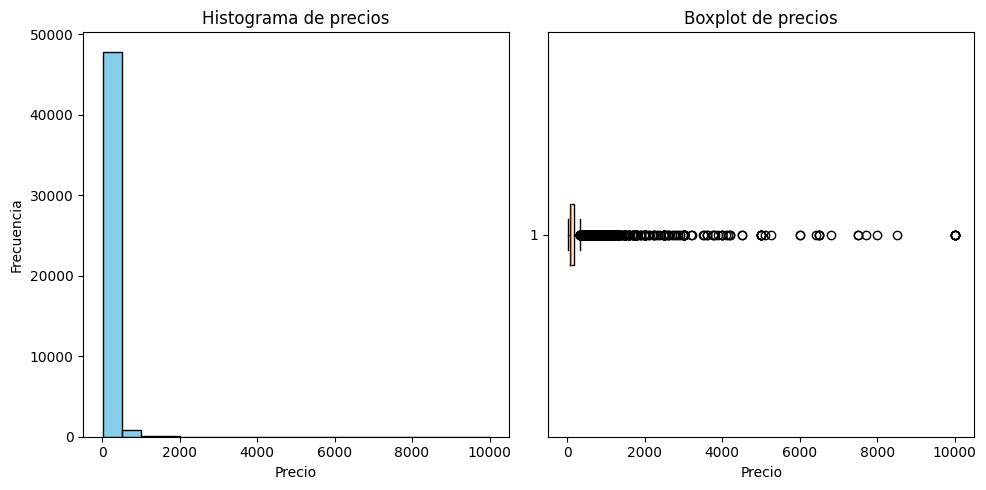

In [94]:
#Visualización de precio vs frecuencia con hist y boxplot :

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(df['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de precios')
ax[0].set_xlabel('Precio')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('Boxplot de precios')
ax[1].set_xlabel('Precio')

# Mostrar la figura
plt.tight_layout()
plt.show()

In [95]:
# Transformamos la variable respuesta/dependiente/y/target a escala logarítmica

df['log_precios'] = np.log(df['price'])

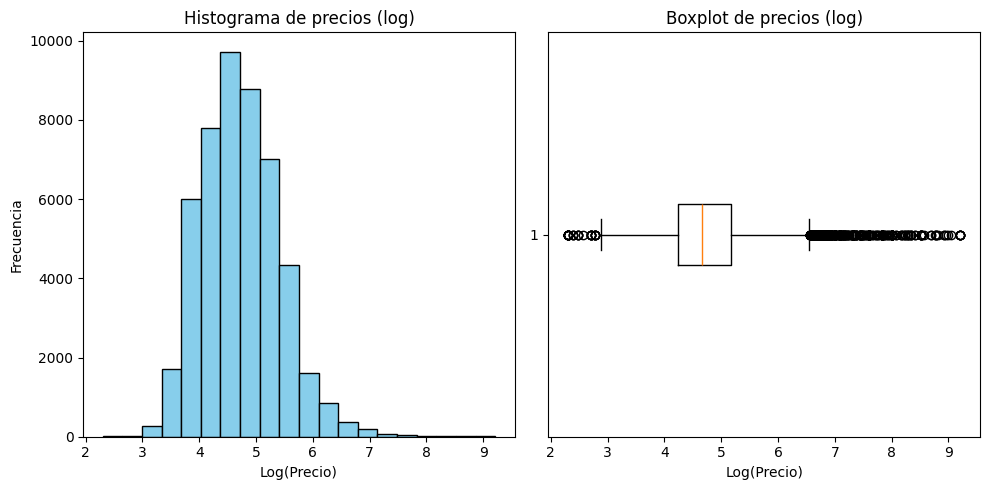

In [96]:
#Volvemos a hacer la visualización : 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Crear un histograma en el primer subplot
ax[0].hist(df['log_precios'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Histograma de precios (log)')
ax[0].set_xlabel('Log(Precio)')
ax[0].set_ylabel('Frecuencia')

# Crear un boxplot en el segundo subplot
ax[1].boxplot(df['log_precios'], vert=False)
ax[1].set_title('Boxplot de precios (log)')
ax[1].set_xlabel('Log(Precio)')

# Mostrar la figura
plt.tight_layout()
plt.show()

In [97]:
# Revisamos los valores faltantes:
df.isnull().mean()*100


id                                 0.00000
host_id                            0.00000
neighbourhood_group                0.00000
neighbourhood                      0.00000
latitude                           0.00000
longitude                          0.00000
room_type                          0.00000
price                              0.00000
minimum_nights                     0.00000
number_of_reviews                  0.00000
last_review                       20.56092
reviews_per_month                 20.56092
calculated_host_listings_count     0.00000
availability_365                   0.00000
log_precios                        0.00000
dtype: float64

<Axes: >

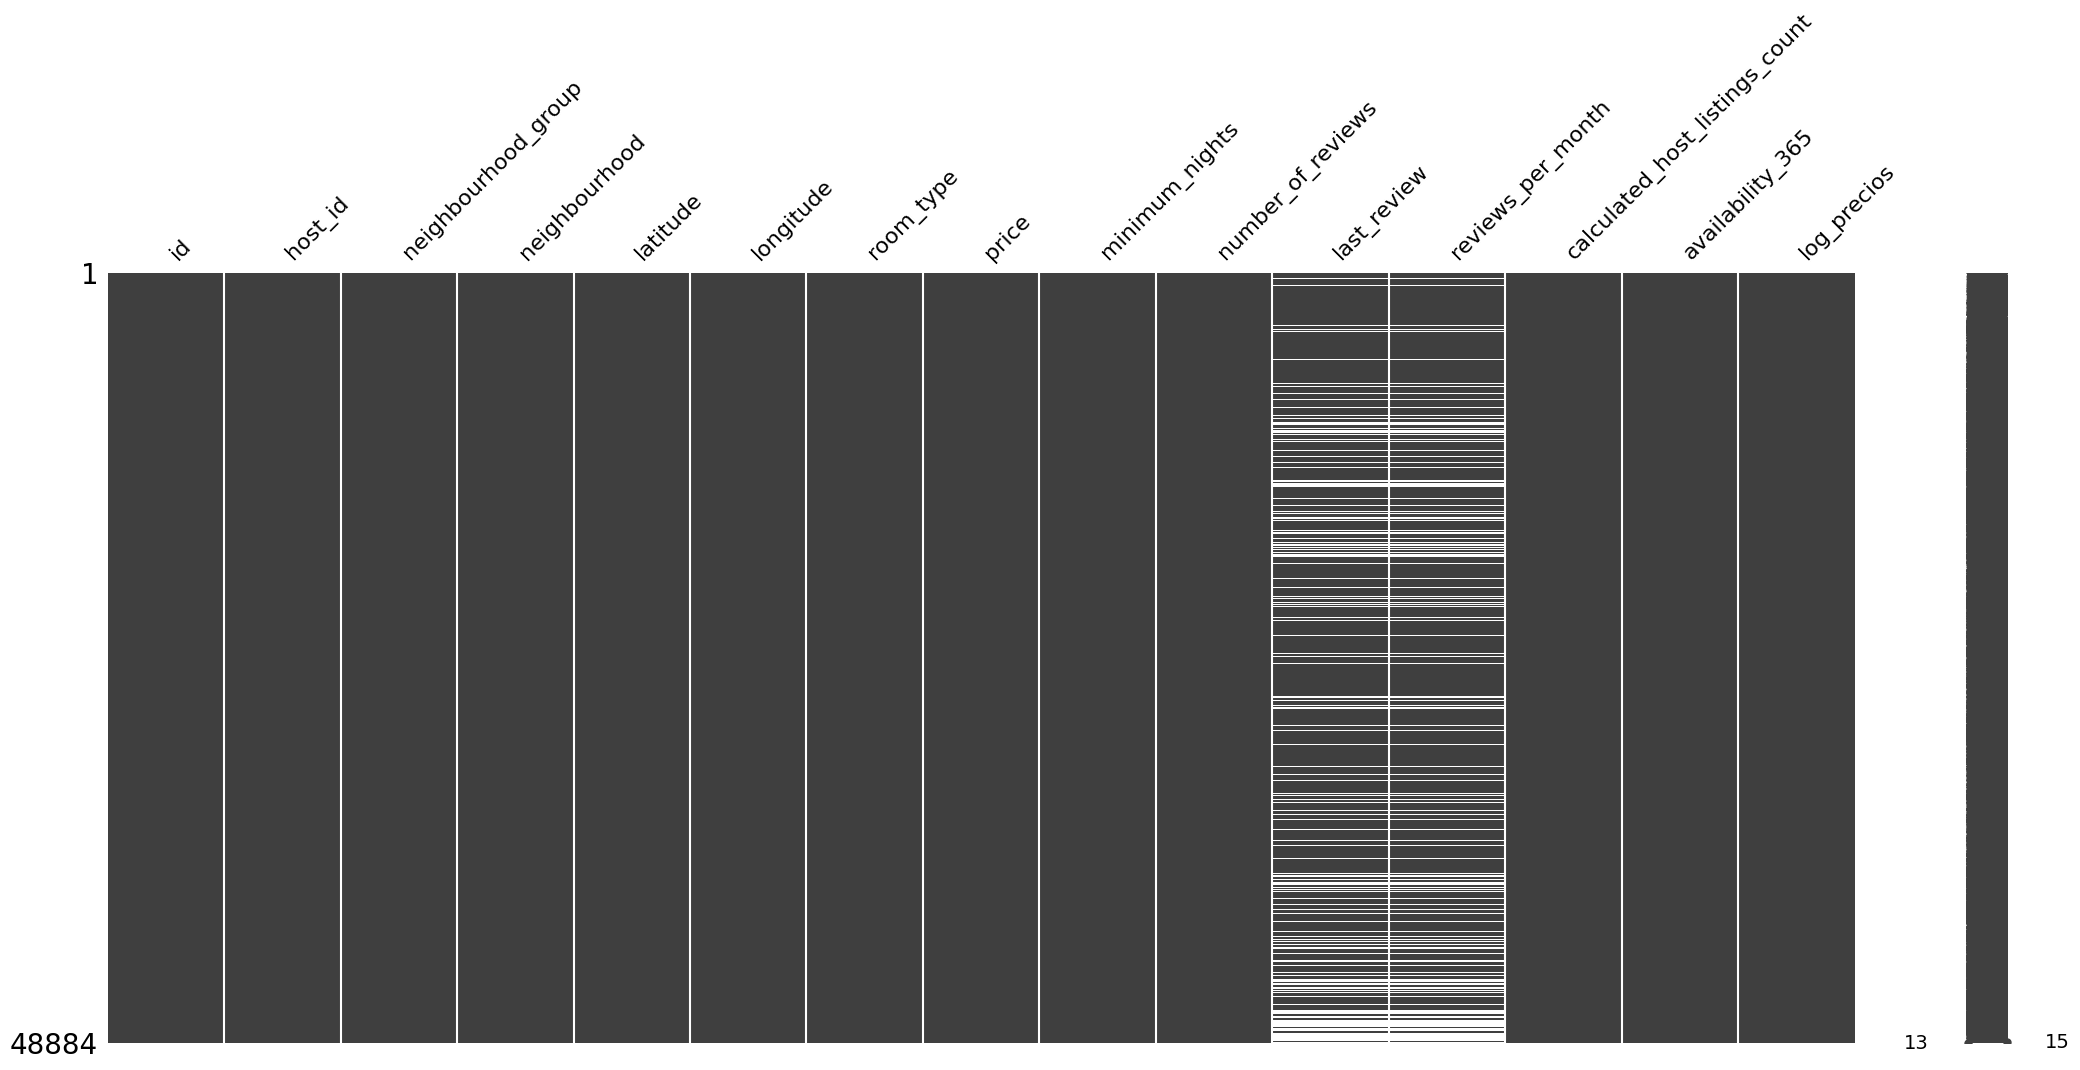

In [98]:
#Y lo vizualisamos : 

msno.matrix(df)

Observamos que 1/5 de de las lineas de last_reviews y review_x_month tienen valores nulas 
Para esas 2 columnas, son exactamente las mismas lineas que tienen los nulos (lo que es lógico porque si no hay last_review significaría que no hay ninguna review y entonces 0 x month)

Aquí nos toca elegir que hacer con esas columna, si reemplazamos valores nulas para usarlas en la predicción (unir 2 cat, hacer promedios, knn ...) o si eliminamos columnas

In [99]:
#En este caso eliminamos esas columnas porque les faltan muchos datos y la fechas de las reviews no es un indicador que influya de manera fuerte en los precios. Y tenemos el num de reviews.

#Y eliminamos también "neighbourhood" porque hay 221 barrios, que ya están ordenados en 5 neighbourhood_group.   

df.drop(['last_review', 'reviews_per_month', 'neighbourhood'], axis=1, inplace=True)



In [100]:
#Comprobamos que se haya elimindo :
print(df.isnull().mean()*100)
print(df.shape)

id                                0.0
host_id                           0.0
neighbourhood_group               0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
log_precios                       0.0
dtype: float64
(48884, 12)


In [101]:
#neighbourhood_group : hay 5, los reemplazamos por el porcentaje de veces que aparece cada valor = transformamos valores cat en num, más fácil de usar despues para el modelo de ML.
#Dara una idea de la "fama" del barrio: mide cuánto popular o frecuentemente representado es cada barrio

#Frecuencias de cada valor en 'neighbourhood_group':
frequencies_group = (df['neighbourhood_group'].value_counts())/len(df)*100

# Reemplazar los valores de 'neighbourhood_group' con los porcentajes
df['nb_group_percentage'] = df['neighbourhood_group'].map(frequencies_group).round(2)

#Chequeamos : 
print(df['nb_group_percentage'].head())


0    41.11
1    44.31
2    44.31
3    41.11
4    44.31
Name: nb_group_percentage, dtype: float64


In [102]:
#room_type : hay solo 3: 
print(df['room_type'].unique())

#Podemos ordenar esas opciones muy facilmente de la mejor a la peor, y eso es un factor importante que influye en el precio y que será útil para el modelo de ML
#Transformamos entonces esas valores cat en num, con un ranking de 1 a 3, 1 la mejor opción : 

ranking = {
    'Entire home/apt': 1,  
    'Private room': 2,     
    'Shared room': 3       
}

df['ranking_room_type'] = df['room_type'].map(ranking)

#Chequeamos :
print(df['ranking_room_type'].head())

['Private room' 'Entire home/apt' 'Shared room']
0    2
1    1
2    2
3    1
4    1
Name: ranking_room_type, dtype: int64


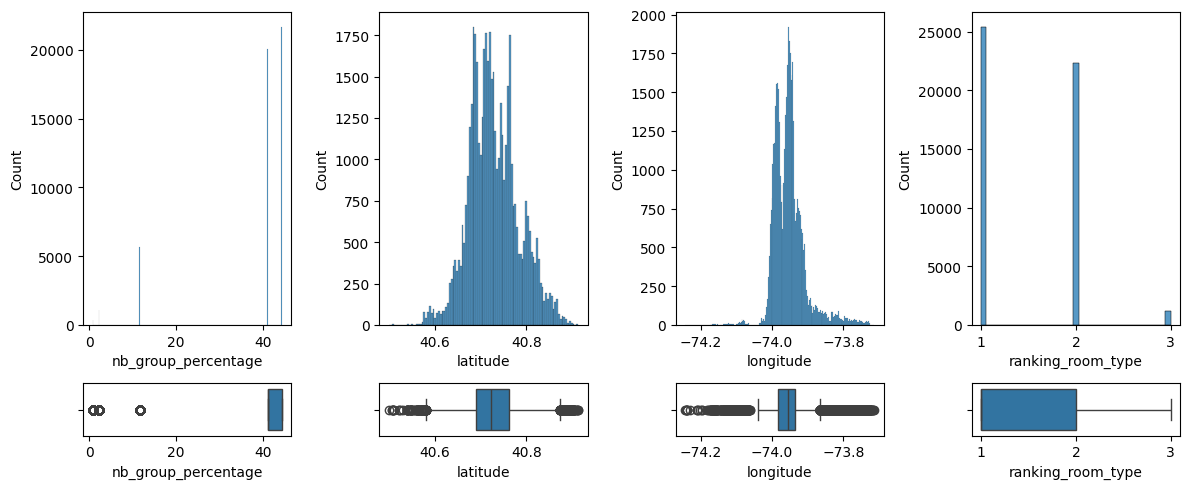

In [103]:
# Variables numéricas:

fig, axis = plt.subplots(2, 4, figsize=(12, 5), gridspec_kw={"height_ratios": [6, 1]})  # Ajustamos para que los boxplots sean más pequeños

sns.histplot(ax=axis[0, 0], data=df, x="nb_group_percentage")
sns.histplot(ax=axis[0, 1], data=df, x="latitude")
sns.histplot(ax=axis[0, 2], data=df, x="longitude")
sns.histplot(ax=axis[0, 3], data=df, x="ranking_room_type")

sns.boxplot(ax=axis[1, 0], data=df, x="nb_group_percentage")
sns.boxplot(ax=axis[1, 1], data=df, x="latitude")
sns.boxplot(ax=axis[1, 2], data=df, x="longitude")
sns.boxplot(ax=axis[1, 3], data=df, x="ranking_room_type")

plt.tight_layout()

plt.show()


In [104]:
#Identificar observaciones influyentes

#Speramos indep y dep --> Seleccionar solo las columnas numéricas y dependientes (sin precios ni log_precios, sin categoricas):
num_dep_var = ['nb_group_percentage', 'latitude', 'longitude', 'minimum_nights',
                   'number_of_reviews', 'calculated_host_listings_count', 'availability_365', 
                   'ranking_room_type'] 

X = df[num_dep_var]
y = df['log_precios']

# Ajustar el modelo de regresión lineal
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

# Instancia de la influencia y obtención de la distancia de cook para cada observación
cooks_distance = model.get_influence().cooks_distance



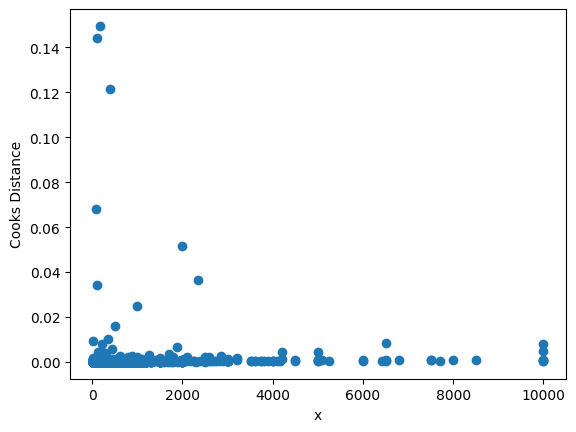

In [105]:
plt.scatter(df.price, cooks_distance[0])
plt.xlabel('x')
plt.ylabel('Cooks Distance')
plt.show()

In [106]:
cooks_distance

(array([1.56783827e-05, 4.58590950e-08, 8.06998638e-06, ...,
        8.73208870e-06, 6.45971278e-06, 5.15802299e-10], shape=(48884,)),
 array([1., 1., 1., ..., 1., 1., 1.], shape=(48884,)))

In [107]:
#Vamos a mirar más en detalles los 3 puntos más arriba :
np.where(cooks_distance[0]>0.12)

(array([ 2854,  5767, 38653]),)

In [108]:
df.iloc[2854,]

id                                        1615764
host_id                                   6676776
neighbourhood_group                     Manhattan
latitude                                 40.71239
longitude                                -74.0162
room_type                         Entire home/apt
price                                         400
minimum_nights                               1000
number_of_reviews                               0
calculated_host_listings_count                  1
availability_365                              362
log_precios                              5.991465
nb_group_percentage                         44.31
ranking_room_type                               1
Name: 2854, dtype: object

In [109]:
df.iloc[5767,]

id                                        4204302
host_id                                  17550546
neighbourhood_group                     Manhattan
latitude                                 40.73293
longitude                               -73.99782
room_type                         Entire home/apt
price                                         180
minimum_nights                               1250
number_of_reviews                               2
calculated_host_listings_count                  1
availability_365                              365
log_precios                              5.192957
nb_group_percentage                         44.31
ranking_room_type                               1
Name: 5767, dtype: object

In [110]:
df.iloc[38653,]

id                                   30378211
host_id                             200401254
neighbourhood_group                 Manhattan
latitude                             40.73094
longitude                             -73.999
room_type                         Shared room
price                                     110
minimum_nights                            999
number_of_reviews                           0
calculated_host_listings_count              1
availability_365                          365
log_precios                           4.70048
nb_group_percentage                     44.31
ranking_room_type                           3
Name: 38664, dtype: object

In [111]:
#No tiene sentido sus numéros de noche minimas, es normal quitarlas de la análisis.
#Buscamos más usando punto de corte para la distancia de cook:
pto_corte = 4/len(df)

# Viviendas por encima del pto de corte
len(np.where(cooks_distance[0]>pto_corte)[0]) #Se va a imprimir el num de vivienda por las cuales no es aconsejable incluirlas en la analisis:

2171

In [112]:
# Eliminar observaciones que se consideran influentes
df1 = df.drop(np.where(cooks_distance[0]>pto_corte)[0])

In [113]:
#Chequeamos : 
df1.duplicated().sum()

np.int64(0)

In [114]:
#Ahora hemos hecho una analisis y cambios que nos parecen una base relevante para ya empezar a trabajar sobre un modelo de ML

# Podemos entonces definir X (features) e Y (target) para dividir el data set entre set y train:

X = df1.drop(['price'], axis=1)  # Eliminar la columna 'price' de las características
y = df1['price']  # La columna 'price' es el target

# Dividir el dataset en train y test (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Paso 3: Guarda el conjunto de datos procesado
Después del EDA puedes guardar los datos en la carpeta ./data/processed. Asegúrate de agregar la carpeta de los datos en el .gitignore. Los datos al igual que los modelos no se deben subir a git.

In [115]:
# Crear carpeta y guardar el df:
os.makedirs('./data/processed', exist_ok=True)
df1.to_csv('./data/processed/processed_data.csv', index=False)